In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import re
import string   
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.chunk import tree2conlltags

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\navin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\navin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\navin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\navin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\navin\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\navin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-

In [6]:
columns = ["Id","Entity","Target","Text"]
data = pd.read_csv("twitter_training.csv",
                   names=columns,header=None)

In [7]:
data.head()

,Id,Entity,Target,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
df = data[["Text","Target"]]

In [9]:
df.head()

,Text,Target
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive


In [10]:
df.shape

(74682, 2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    73996 non-null  object
 1   Target  74682 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [12]:
df= df.drop_duplicates()

<AxesSubplot:xlabel='Target', ylabel='count'>

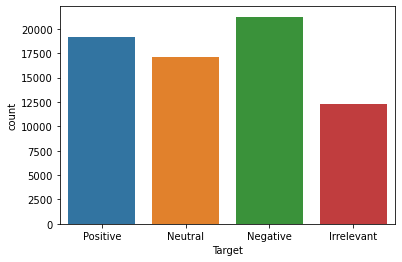

In [13]:
sns.countplot(x="Target",data=df)

In [14]:
sentiment = []

for i in df["Target"]:
    if i == "Positive":
        sentiment.append(1)
    elif (i == "Irrelevant") or (i == "Neutral"):
        sentiment.append(0)
    else:
        sentiment.append(-1)
df["Sentiment"] = sentiment

In [15]:
df.head()

,Text,Target,Sentiment
0,im getting on borderlands and i will murder yo...,Positive,1
1,I am coming to the borders and I will kill you...,Positive,1
2,im getting on borderlands and i will kill you ...,Positive,1
3,im coming on borderlands and i will murder you...,Positive,1
4,im getting on borderlands 2 and i will murder ...,Positive,1


In [16]:
stop_words = set(stopwords.words("english"))

# Text Cleaner

In [17]:
df["Text"] = df["Text"].str.replace("\d","")

In [18]:
def cleaner(data):
    # Tokens
    tokens = word_tokenize(str(data).replace("'", "").lower()) 
    
    # Remove Puncs
    without_punc = [w for w in tokens if w.isalpha()]
    
    # Stopwords
    without_sw = [t for t in without_punc if t not in stop_words]
    
    # Lemmatize
    text_len = [WordNetLemmatizer().lemmatize(t) for t in without_sw]
    # Stem
    text_cleaned = [PorterStemmer().stem(w) for w in text_len]
    
    return " ".join(text_cleaned)

In [19]:
df["Text"] = df["Text"].apply(cleaner)
df["Text"].head()

0     im get borderland murder
1             come border kill
2       im get borderland kill
3    im come borderland murder
4     im get borderland murder
Name: Text, dtype: object

In [20]:
df["Text"]=df["Text"].str.replace("im","")
df["Text"].head()

0      get borderland murder
1           come border kill
2        get borderland kill
3     come borderland murder
4      get borderland murder
Name: Text, dtype: object

# Rare Words

In [21]:
rare_words = pd.Series(" ".join(df["Text"]).split()).value_counts()
rare_words

game            10787
play             6822
get              5567
like             5153
go               4216
                ...  
spokesperson        1
tgo                 1
thatwhat            1
hentaithick         1
adh                 1
Length: 22234, dtype: int64

In [22]:
rare_words = rare_words[rare_words <= 2]

In [23]:
df["Text"] = df["Text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
df

,Text,Target,Sentiment
0,get borderland murder,Positive,1
1,come border kill,Positive,1
2,get borderland kill,Positive,1
3,come borderland murder,Positive,1
4,get borderland murder,Positive,1
...,...,...,...
74677,realiz window partit mac like year behind nvid...,Positive,1
74678,realiz mac window partit year behind nvidia dr...,Positive,1
74679,realiz window partit mac year behind nvidia dr...,Positive,1
74680,realiz window partit mac like year behind nvid...,Positive,1


# Word Cloud

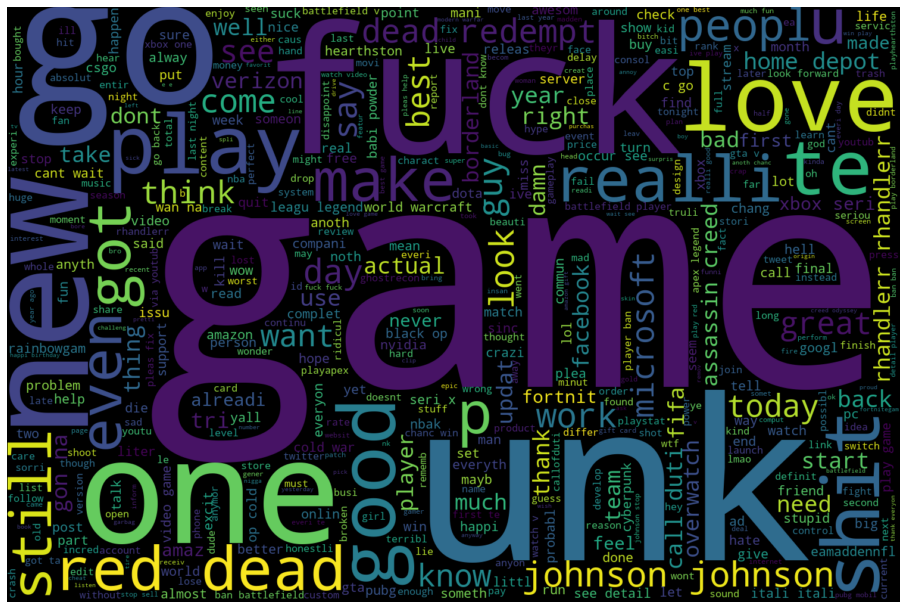

In [24]:
plt.figure(figsize=(16,12))
wordcloud = WordCloud(background_color="black",max_words=500, width=1500, height=1000).generate(' '.join(df['Text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Train test split

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.ensemble import RandomForestClassifier

In [26]:
X = df["Text"]
y = df["Sentiment"]

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

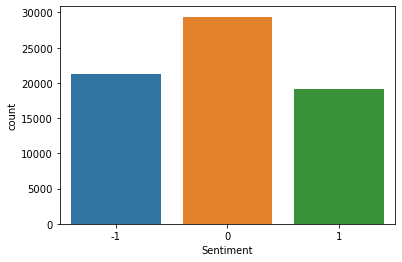

In [27]:
sns.countplot(y,data=df)

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.30,random_state= 42,stratify = y)
print("X_train : "+X_train)
print("X_test : "+X_test)
print("y_train :")
y_train
print("y_test :")
y_test

66597    X_train : covid big shock hiv vaccin johnson j...
13034                                   X_train : thank nk
60904    X_train : rockstarsupport hi screen comput nam...
36582    X_train : latest fabien henon le journal thank...
4363     X_train : cant wait lick gipper boot sick waif...
                               ...                        
67570                                    X_train : go well
51908          X_train : red dead redeem realli masterpiec
35411           X_train : would say ban microsoft day come
21413    X_train : yet solv thiz csgo issu alreadi make...
12679    X_train : obvious guy much better vr realiti i...
Name: Text, Length: 48841, dtype: object
44800    X_test : unk sure afternoon data go frustrat f...
33815     X_test : brother loox ag video big ghost gg http
32677    X_test : make happi know creativ commun come t...
5489     X_test : proud vex moron whilst request l mana...
34051                               X_test : hit clip http
               

44800    0
33815    0
32677    0
5489    -1
34051    1
        ..
66338    0
32118    1
1152     1
58062   -1
14015    0
Name: Sentiment, Length: 20932, dtype: int64

# Count Vectorizer

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
vt = CountVectorizer(analyzer="word")
X_train_count = vt.fit_transform(X_train)
X_test_count = vt.transform(X_test)
print(vt.vocabulary_)

{'covid': 2565, 'big': 1152, 'shock': 10932, 'hiv': 5540, 'vaccin': 13066, 'johnson': 6318, 'stop': 11647, 'trial': 12561, 'thank': 12177, 'nk': 8235, 'rockstarsupport': 10247, 'hi': 5489, 'screen': 10641, 'comput': 2379, 'name': 8014, 'zen': 14032, 'new': 8136, 'grand': 5050, 'theft': 12203, 'auto': 758, 'onlin': 8535, 'bought': 1426, 'whale': 13526, 'cash': 1842, 'insur': 5983, 'card': 1807, 'exact': 3920, 'th': 12172, 'april': 540, 'havent': 5339, 'entir': 3769, 'receiv': 9810, 'bonu': 1371, 'yet': 13928, 'whole': 13572, 'day': 2883, 'andov': 419, 'hour': 5662, 'latest': 6771, 'fabien': 4008, 'henon': 5457, 'le': 6809, 'journal': 6355, 'elixirtip': 3670, 'cant': 1779, 'wait': 13349, 'lick': 6913, 'gipper': 4848, 'boot': 1392, 'sick': 10997, 'waifu': 13346, 'pistol': 9072, 'skin': 11087, 'sell': 10726, 'whiten': 13561, 'cream': 2616, 'concern': 2389, 'racism': 9639, 'hors': 5644, 'behind': 1046, 'punk': 9526, 'tool': 12439, 'destruct': 3079, 'exactli': 3921, 'democrat': 3016, 'care':

In [34]:
print(X_train_count.toarray())
X_train_count

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<48841x14108 sparse matrix of type '<class 'numpy.int64'>'
	with 480354 stored elements in Compressed Sparse Row format>

# MultinomialNB

In [30]:
nb_model = MultinomialNB()
nb_model.fit(X_train_count,y_train)

MultinomialNB()

In [31]:
nb_pred = nb_model.predict(X_test_count)
nb_train_pred = nb_model.predict(X_train_count)

X Test
              precision    recall  f1-score   support

          -1       0.72      0.77      0.75      6371
           0       0.78      0.71      0.74      8819
           1       0.69      0.73      0.71      5742

    accuracy                           0.73     20932
   macro avg       0.73      0.74      0.73     20932
weighted avg       0.74      0.73      0.73     20932

X Train
              precision    recall  f1-score   support

          -1       0.76      0.81      0.78     14867
           0       0.81      0.75      0.78     20577
           1       0.74      0.78      0.76     13397

    accuracy                           0.77     48841
   macro avg       0.77      0.78      0.77     48841
weighted avg       0.78      0.77      0.77     48841



<AxesSubplot:>

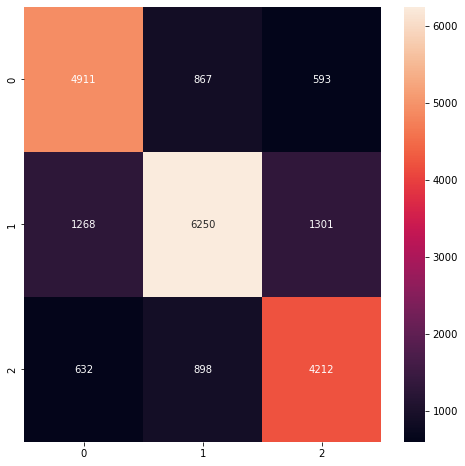

In [32]:
print("X Test")
print(classification_report(y_test,nb_pred))
print("X Train")
print(classification_report(y_train,nb_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,nb_pred),annot = True,fmt = "d")

In [38]:
from yellowbrick.classifier import PrecisionRecallCurve

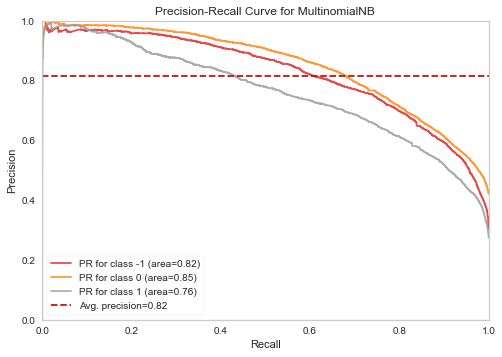

In [39]:
viz = PrecisionRecallCurve(MultinomialNB(),
                           classes=nb_model.classes_,
                           per_class=True,
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

# Random Forest

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
rf_params = {"max_depth": [2,4,6,10,12],
            "max_features": [2,5,7],
            "n_estimators":[12,15,16,]}
rf = RandomForestClassifier()

In [42]:
rf_model_cv = GridSearchCV(rf,rf_params,cv = 5,n_jobs = -1)

In [43]:
rf_model_cv.fit(X_train_count,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 10, 12],
                         'max_features': [2, 5, 7],
                         'n_estimators': [12, 15, 16]})

In [44]:
rf_model_cv.best_params_

{'max_depth': 12, 'max_features': 7, 'n_estimators': 12}

In [45]:
rf_tuned = RandomForestClassifier(max_depth = 12,
                                 max_features = 7,
                                 min_samples_split = 2,
                                 n_estimators = 100).fit(X_train_count,y_train)

In [46]:
rf_pred = rf_tuned.predict(X_test_count)
rf_train_pred = rf_tuned.predict(X_train_count)

X Test
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      6371
           0       0.42      1.00      0.59      8819
           1       0.00      0.00      0.00      5742

    accuracy                           0.42     20932
   macro avg       0.14      0.33      0.20     20932
weighted avg       0.18      0.42      0.25     20932

X Train
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     14867
           0       0.42      1.00      0.59     20577
           1       0.00      0.00      0.00     13397

    accuracy                           0.42     48841
   macro avg       0.14      0.33      0.20     48841
weighted avg       0.18      0.42      0.25     48841



<AxesSubplot:>

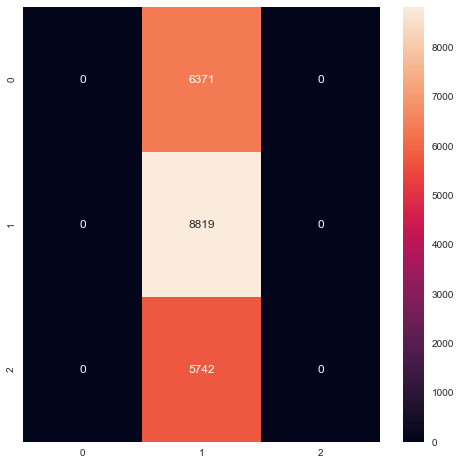

In [47]:
print("X Test")
print(classification_report(y_test,rf_pred))
print("X Train")
print(classification_report(y_train,rf_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,rf_pred),annot = True,fmt = "d")

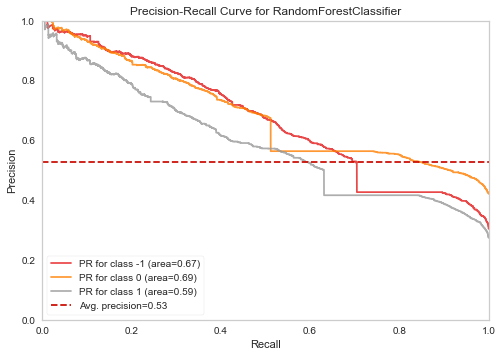

In [49]:
viz = PrecisionRecallCurve(RandomForestClassifier(max_depth = 10,
                                 max_features = 10,
                                 min_samples_split = 2,
                                 n_estimators = 100),
                                 classes=rf_tuned.classes_,
                                 per_class=True,
                                 cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

# KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier

In [51]:
knn = KNeighborsClassifier()

In [52]:
knn_model = knn.fit(X_train_count,y_train)

In [53]:
knn_pred = knn_model.predict(X_test_count)
knn_train_pred = knn_model.predict(X_train_count)

X Test
              precision    recall  f1-score   support

          -1       0.83      0.86      0.84      6371
           0       0.86      0.82      0.84      8819
           1       0.81      0.82      0.82      5742

    accuracy                           0.83     20932
   macro avg       0.83      0.84      0.83     20932
weighted avg       0.84      0.83      0.83     20932

X Train
              precision    recall  f1-score   support

          -1       0.92      0.94      0.92     14867
           0       0.93      0.92      0.92     20577
           1       0.92      0.91      0.91     13397

    accuracy                           0.92     48841
   macro avg       0.92      0.92      0.92     48841
weighted avg       0.92      0.92      0.92     48841



<AxesSubplot:>

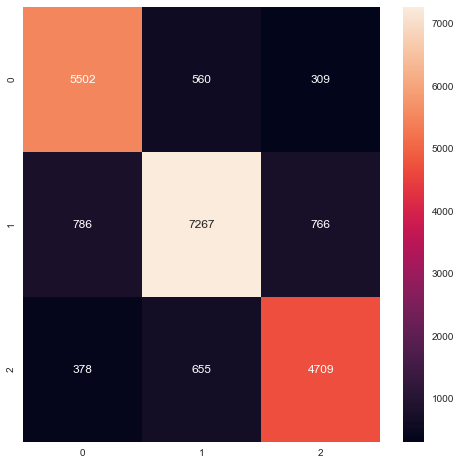

In [54]:
print("X Test")
print(classification_report(y_test,y_test_prediction))
print("X Train")
print(classification_report(y_train,y_train_prediction))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,knn_pred),annot = True,fmt = "d")

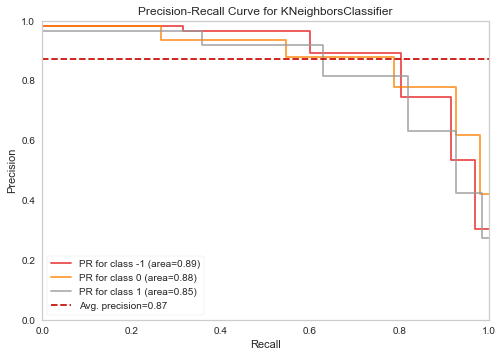

In [55]:
viz = PrecisionRecallCurve(KNeighborsClassifier(),
                           classes=knn_model.classes_,
                           per_class=True,
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

# SVM

In [56]:
from sklearn.svm import SVC

In [57]:
svc_model = SVC().fit(X_train_count,y_train)

In [59]:
svc_pred = svc_model.predict(X_test_count)
svc_train_pred = svc_model.predict(X_train_count)

X Test
              precision    recall  f1-score   support

          -1       0.89      0.85      0.87      6371
           0       0.83      0.90      0.87      8819
           1       0.86      0.80      0.83      5742

    accuracy                           0.86     20932
   macro avg       0.86      0.85      0.86     20932
weighted avg       0.86      0.86      0.86     20932

X Train
              precision    recall  f1-score   support

          -1       0.94      0.90      0.92     14867
           0       0.89      0.95      0.92     20577
           1       0.93      0.88      0.90     13397

    accuracy                           0.92     48841
   macro avg       0.92      0.91      0.92     48841
weighted avg       0.92      0.92      0.92     48841



<AxesSubplot:>

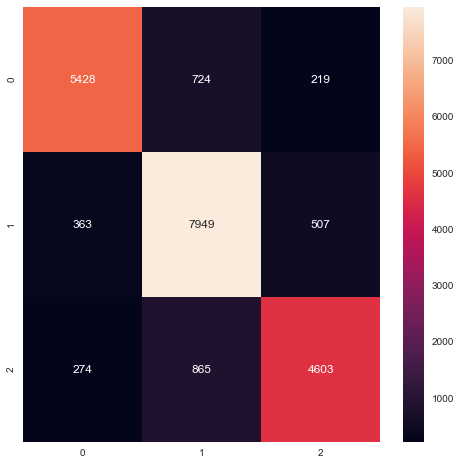

In [60]:
print("X Test")
print(classification_report(y_test,svc_pred))
print("X Train")
print(classification_report(y_train,svc_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,svc_pred),annot = True,fmt = "d")

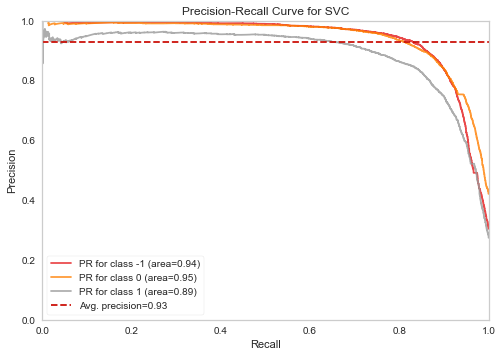

In [61]:
viz = PrecisionRecallCurve(SVC(),
                           classes=svc_model.classes_,
                           per_class=True,
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [62]:
pred_df = pd.DataFrame({"MultinomialNB":[accuracy_score(y_test,nb_pred)],
                      "Random Forest": [accuracy_score(y_test,rf_pred)],
                      "KNN": [accuracy_score(y_test,knn_pred)],
                       "SVC": [accuracy_score(y_test,svc_pred)]})

train_pred = pd.DataFrame({"MultinomialNB":[accuracy_score(y_train,nb_train_pred)],
                      "Random Forest": [accuracy_score(y_train,rf_train_pred)],
                      "KNN": [accuracy_score(y_train,knn_train_pred)],
                       "SVC": [accuracy_score(y_test,svc_pred)]})

<AxesSubplot:>

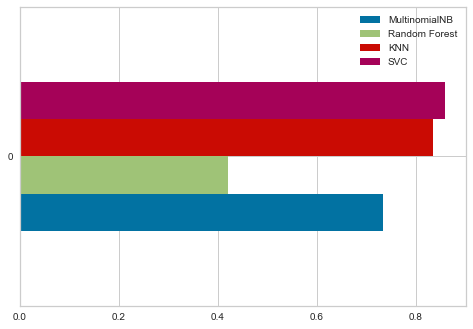

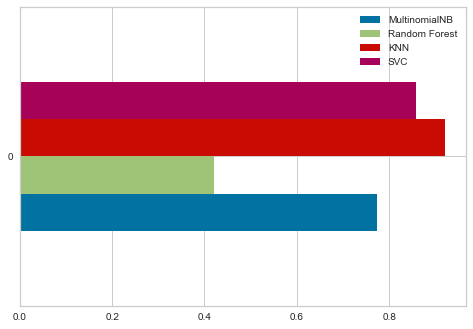

In [63]:
pred_df.plot(kind="barh")
train_pred.plot(kind="barh")